# Strategy 1: Trend Confirmation Entry

## Strategy Rules
- **Long Entry:** Price closes above 20-day high + Volume > 1.5x 20-day avg + AGG_OI increases > 2% from prior day
- **Short Entry:** Price closes below 20-day low + Volume > 1.5x 20-day avg + AGG_OI increases > 2%
- **Exit:** Trailing stop at 2x ATR(14) OR AGG_OI declines for 3 consecutive days
- **Stop Loss:** 1.5x ATR(14) from entry

## Data
- Price: F1_RolledPrice (WTI CL continuous front-month)
- Volume: F1_Volume
- Open Interest: AGG_OI (aggregate across all contracts)

## Cell 1: Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# Strategy Parameters
LOOKBACK_PERIOD = 20          # Days for high/low breakout
VOLUME_MULTIPLIER = 1.5       # Volume must be > this * 20d avg
OI_CHANGE_THRESHOLD = 0.02    # OI must increase by > 2%
ATR_PERIOD = 14               # ATR calculation period
STOP_LOSS_ATR_MULT = 1.5      # Stop loss = 1.5x ATR from entry
TRAILING_STOP_ATR_MULT = 2.0  # Trailing stop = 2x ATR
OI_DECLINE_EXIT_DAYS = 3      # Exit if OI declines for N consecutive days

# Cost assumptions
SLIPPAGE_AND_COMMISSION = 5   # $ per round-trip trade
POINT_VALUE = 1000            # WTI CL contract: $1000 per point

# Data paths
DATA_DIR = Path('../../cache/raw_data')

print("Configuration loaded successfully")
print(f"Strategy: {LOOKBACK_PERIOD}-day breakout with Volume > {VOLUME_MULTIPLIER}x avg and OI change > {OI_CHANGE_THRESHOLD*100}%")

Configuration loaded successfully
Strategy: 20-day breakout with Volume > 1.5x avg and OI change > 2.0%


## Cell 2: Load Data

In [2]:
# Load data files
prices_df = pd.read_csv(DATA_DIR / 'prices_db.csv', index_col=0)
oi_df = pd.read_csv(DATA_DIR / 'openinterest_db.csv', index_col=0)
volume_df = pd.read_csv(DATA_DIR / 'volume_db.csv', index_col=0)

# Filter for CL (WTI) only
prices_df = prices_df[prices_df['Name'] == 'CL'].copy()
oi_df = oi_df[oi_df['Name'] == 'CL'].copy()
volume_df = volume_df[volume_df['Name'] == 'CL'].copy()

# Clean volume_df (has an extra header row)
volume_df = volume_df[volume_df['tradeDate'].notna() & (volume_df['tradeDate'] != '')].copy()

# Convert dates
prices_df['tradeDate'] = pd.to_datetime(prices_df['tradeDate'])
oi_df['tradeDate'] = pd.to_datetime(oi_df['tradeDate'])
volume_df['tradeDate'] = pd.to_datetime(volume_df['tradeDate'])

# Merge datasets
df = prices_df[['tradeDate', 'F1_RolledPrice']].merge(
    oi_df[['tradeDate', 'AGG_OI']], on='tradeDate', how='inner'
).merge(
    volume_df[['tradeDate', 'F1_Volume']], on='tradeDate', how='inner'
)

# Sort by date and reset index
df = df.sort_values('tradeDate').reset_index(drop=True)

# Convert to numeric
df['F1_RolledPrice'] = pd.to_numeric(df['F1_RolledPrice'], errors='coerce')
df['AGG_OI'] = pd.to_numeric(df['AGG_OI'], errors='coerce')
df['F1_Volume'] = pd.to_numeric(df['F1_Volume'], errors='coerce')

# Rename columns for clarity
df.columns = ['date', 'price', 'oi', 'volume']

print(f"Data loaded: {len(df)} rows")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nData preview:")
df.head(10)

Data loaded: 3920 rows
Date range: 2010-01-04 00:00:00 to 2025-07-29 00:00:00

Data preview:


,date,price,oi,volume
0,2010-01-04,104.06,1241859.0,263542.0
1,2010-01-05,104.32,1231436.0,258887.0
2,2010-01-06,105.73,1264706.0,370059.0
3,2010-01-07,105.21,1277089.0,246632.0
4,2010-01-08,105.30,1289625.0,310377.0
5,2010-01-11,105.07,1294224.0,296304.0
6,2010-01-12,103.34,1300867.0,333866.0
7,2010-01-13,102.20,1316280.0,401627.0
8,2010-01-14,101.94,1347402.0,275404.0
9,2010-01-15,100.55,1330155.0,200555.0


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nData shape: {df.shape}")

# Drop any rows with missing values
df = df.dropna().reset_index(drop=True)
print(f"After dropping NaN: {df.shape}")

Missing values:
date      0
price     0
oi        0
volume    0
dtype: int64

Data shape: (3920, 4)
After dropping NaN: (3920, 4)


## Cell 3: Feature Engineering

In [4]:
# 20-day rolling high and low (excluding current day for breakout detection)
df['high_20d'] = df['price'].shift(1).rolling(window=LOOKBACK_PERIOD).max()
df['low_20d'] = df['price'].shift(1).rolling(window=LOOKBACK_PERIOD).min()

# 20-day average volume
df['volume_avg_20d'] = df['volume'].shift(1).rolling(window=LOOKBACK_PERIOD).mean()

# OI daily percentage change
df['oi_pct_change'] = df['oi'].pct_change()

# OI consecutive decline counter (for exit signal)
df['oi_declining'] = (df['oi_pct_change'] < 0).astype(int)
# Count consecutive declining days
df['oi_decline_streak'] = df['oi_declining'].groupby(
    (df['oi_declining'] != df['oi_declining'].shift()).cumsum()
).cumsum() * df['oi_declining']

# ATR(14) calculation
df['prev_close'] = df['price'].shift(1)
df['high'] = df['price']  # Using close as proxy (we don't have intraday high/low)
df['low'] = df['price']   # Using close as proxy

# For ATR, we'll use price changes as a proxy since we only have close prices
df['tr'] = abs(df['price'] - df['prev_close'])
# Add some volatility estimation using rolling std
df['price_std'] = df['price'].rolling(window=ATR_PERIOD).std()
# ATR proxy: use rolling std * 1.5 as a reasonable estimate
df['atr'] = df['price'].rolling(window=ATR_PERIOD).std() * 1.5

print("Features created:")
print(f"  - high_20d: {LOOKBACK_PERIOD}-day rolling high")
print(f"  - low_20d: {LOOKBACK_PERIOD}-day rolling low")
print(f"  - volume_avg_20d: {LOOKBACK_PERIOD}-day average volume")
print(f"  - oi_pct_change: Daily OI % change")
print(f"  - oi_decline_streak: Consecutive days of OI decline")
print(f"  - atr: {ATR_PERIOD}-day ATR proxy")
print(f"\nFeature preview:")
df[['date', 'price', 'high_20d', 'low_20d', 'volume', 'volume_avg_20d', 'oi_pct_change', 'atr']].tail(10)

Features created:
  - high_20d: 20-day rolling high
  - low_20d: 20-day rolling low
  - volume_avg_20d: 20-day average volume
  - oi_pct_change: Daily OI % change
  - oi_decline_streak: Consecutive days of OI decline
  - atr: 14-day ATR proxy

Feature preview:


,date,price,high_20d,low_20d,volume,volume_avg_20d,oi_pct_change,atr
3910,2025-07-16,65.09,72.55,63.08,248346.0,266405.15,0.006652,1.784017
3911,2025-07-17,66.25,72.55,63.08,188802.0,260456.85,-0.013903,1.668724
3912,2025-07-18,66.05,72.55,63.08,107628.0,262183.75,-0.000351,1.549884
3913,2025-07-21,65.95,72.55,63.08,81194.0,262407.15,-0.016869,1.289365
3914,2025-07-22,65.31,67.22,63.08,18614.0,264764.55,-0.002598,1.075529
3915,2025-07-23,65.25,67.16,63.08,251825.0,229251.85,-0.002536,1.119855
3916,2025-07-24,66.03,67.16,63.63,281209.0,214769.35,0.002320,1.113763
3917,2025-07-25,65.16,67.16,63.82,234283.0,214904.60,0.003970,1.125528
3918,2025-07-28,66.71,67.16,63.82,262038.0,214930.20,0.004091,1.074211
3919,2025-07-29,69.21,67.16,63.82,329112.0,216217.90,-0.000080,1.663691


## Cell 4: Signal Generation

In [5]:
# Long signal conditions
df['breakout_up'] = df['price'] > df['high_20d']
df['volume_surge'] = df['volume'] > (VOLUME_MULTIPLIER * df['volume_avg_20d'])
df['oi_increase'] = df['oi_pct_change'] > OI_CHANGE_THRESHOLD

df['long_signal'] = df['breakout_up'] & df['volume_surge'] & df['oi_increase']

# Short signal conditions
df['breakout_down'] = df['price'] < df['low_20d']
df['short_signal'] = df['breakout_down'] & df['volume_surge'] & df['oi_increase']

print("Signal Statistics:")
print(f"  Total trading days: {len(df)}")
print(f"  Days with breakout up: {df['breakout_up'].sum()}")
print(f"  Days with breakout down: {df['breakout_down'].sum()}")
print(f"  Days with volume surge: {df['volume_surge'].sum()}")
print(f"  Days with OI increase > {OI_CHANGE_THRESHOLD*100}%: {df['oi_increase'].sum()}")
print(f"  \n  Long signals: {df['long_signal'].sum()}")
print(f"  Short signals: {df['short_signal'].sum()}")

Signal Statistics:
  Total trading days: 3920
  Days with breakout up: 522
  Days with breakout down: 442
  Days with volume surge: 271
  Days with OI increase > 2.0%: 61
  
  Long signals: 5
  Short signals: 7


In [6]:
# Preview signals
print("\nLong signal days:")
long_signals = df[df['long_signal']][['date', 'price', 'high_20d', 'volume', 'volume_avg_20d', 'oi_pct_change', 'atr']]
print(long_signals.head(20))

print("\nShort signal days:")
short_signals = df[df['short_signal']][['date', 'price', 'low_20d', 'volume', 'volume_avg_20d', 'oi_pct_change', 'atr']]
print(short_signals.head(20))


Long signal days:
           date  price  high_20d     volume  volume_avg_20d  oi_pct_change  \
1426 2015-08-31  47.71     44.75   757503.0       374053.05       0.021769   
1742 2016-11-30  34.38     33.18  1311000.0       609329.45       0.026728   
2030 2018-01-24  45.64     44.50   887018.0       522652.00       0.023930   
2083 2018-04-11  46.91     45.97   963017.0       581460.45       0.021918   
2520 2020-01-03  43.01     41.68   885861.0       428788.15       0.023507   

           atr  
1426  4.248569  
1742  2.355483  
2030  1.709997  
2083  1.977163  
2520  1.168782  

Short signal days:
           date  price  low_20d    volume  volume_avg_20d  oi_pct_change  \
85   2010-05-06  97.32   100.18  605011.0       371834.20       0.027355   
1237 2014-11-28  71.70    79.24  552882.0       292941.50       0.024527   
1267 2015-01-13  51.12    51.30  476541.0       306195.35       0.029025   
1812 2017-03-14  30.42    31.10  857711.0       526899.80       0.020561   
3841 2025-

## Cell 5: Backtest Engine

In [7]:
def run_backtest(df, params):
    """
    Run backtest with given parameters.
    
    Position states: 0 = flat, 1 = long, -1 = short
    """
    trades = []
    position = 0  # flat
    entry_price = 0
    entry_date = None
    entry_atr = 0
    stop_loss = 0
    trailing_stop = 0
    highest_since_entry = 0
    lowest_since_entry = float('inf')
    
    # Drop rows with NaN in required columns
    df_bt = df.dropna(subset=['high_20d', 'low_20d', 'volume_avg_20d', 'atr', 'oi_pct_change']).copy()
    df_bt = df_bt.reset_index(drop=True)
    
    for i in range(len(df_bt)):
        row = df_bt.iloc[i]
        price = row['price']
        date = row['date']
        atr = row['atr']
        oi_decline_streak = row['oi_decline_streak']
        
        # If in a position, check exit conditions
        if position != 0:
            exit_reason = None
            
            if position == 1:  # Long position
                # Update highest price since entry
                highest_since_entry = max(highest_since_entry, price)
                # Update trailing stop
                trailing_stop = max(trailing_stop, highest_since_entry - params['trailing_stop_atr_mult'] * entry_atr)
                
                # Check stop loss
                if price <= stop_loss:
                    exit_reason = 'stop_loss'
                # Check trailing stop
                elif price <= trailing_stop:
                    exit_reason = 'trailing_stop'
                # Check OI decline exit
                elif oi_decline_streak >= params['oi_decline_exit_days']:
                    exit_reason = 'oi_decline'
                    
            elif position == -1:  # Short position
                # Update lowest price since entry
                lowest_since_entry = min(lowest_since_entry, price)
                # Update trailing stop (for shorts, stop is above)
                trailing_stop = min(trailing_stop, lowest_since_entry + params['trailing_stop_atr_mult'] * entry_atr)
                
                # Check stop loss
                if price >= stop_loss:
                    exit_reason = 'stop_loss'
                # Check trailing stop
                elif price >= trailing_stop:
                    exit_reason = 'trailing_stop'
                # Check OI decline exit
                elif oi_decline_streak >= params['oi_decline_exit_days']:
                    exit_reason = 'oi_decline'
            
            # Execute exit
            if exit_reason:
                pnl_points = (price - entry_price) * position
                pnl_dollars = pnl_points * params['point_value'] - params['costs']
                
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': date,
                    'direction': 'long' if position == 1 else 'short',
                    'entry_price': entry_price,
                    'exit_price': price,
                    'pnl_points': pnl_points,
                    'pnl_dollars': pnl_dollars,
                    'exit_reason': exit_reason,
                    'holding_days': (date - entry_date).days
                })
                
                # Reset position
                position = 0
                entry_price = 0
                entry_date = None
                entry_atr = 0
                stop_loss = 0
                trailing_stop = 0
                highest_since_entry = 0
                lowest_since_entry = float('inf')
        
        # If flat, check for entry signals
        if position == 0:
            if row['long_signal']:
                position = 1
                entry_price = price
                entry_date = date
                entry_atr = atr
                stop_loss = price - params['stop_loss_atr_mult'] * atr
                trailing_stop = stop_loss
                highest_since_entry = price
                
            elif row['short_signal']:
                position = -1
                entry_price = price
                entry_date = date
                entry_atr = atr
                stop_loss = price + params['stop_loss_atr_mult'] * atr
                trailing_stop = stop_loss
                lowest_since_entry = price
    
    # Close any open position at the end
    if position != 0:
        final_price = df_bt.iloc[-1]['price']
        final_date = df_bt.iloc[-1]['date']
        pnl_points = (final_price - entry_price) * position
        pnl_dollars = pnl_points * params['point_value'] - params['costs']
        
        trades.append({
            'entry_date': entry_date,
            'exit_date': final_date,
            'direction': 'long' if position == 1 else 'short',
            'entry_price': entry_price,
            'exit_price': final_price,
            'pnl_points': pnl_points,
            'pnl_dollars': pnl_dollars,
            'exit_reason': 'end_of_data',
            'holding_days': (final_date - entry_date).days
        })
    
    return pd.DataFrame(trades)

# Run backtest
params = {
    'stop_loss_atr_mult': STOP_LOSS_ATR_MULT,
    'trailing_stop_atr_mult': TRAILING_STOP_ATR_MULT,
    'oi_decline_exit_days': OI_DECLINE_EXIT_DAYS,
    'point_value': POINT_VALUE,
    'costs': SLIPPAGE_AND_COMMISSION
}

trades_df = run_backtest(df, params)
print(f"Backtest completed: {len(trades_df)} trades")
trades_df

Backtest completed: 10 trades


,entry_date,exit_date,direction,entry_price,exit_price,pnl_points,pnl_dollars,exit_reason,holding_days
0,2010-05-06,2010-05-20,short,97.32,87.72,9.60,9595.0,oi_decline,14
1,2014-11-28,2014-12-18,short,71.70,59.59,12.11,12105.0,oi_decline,20
2,2015-01-13,2015-01-16,short,51.12,53.92,-2.80,-2805.0,oi_decline,3
3,2015-08-31,2015-09-09,long,47.71,42.66,-5.05,-5055.0,oi_decline,9
4,2016-11-30,2016-12-19,long,34.38,36.95,2.57,2565.0,oi_decline,19
5,2017-03-14,2017-03-17,short,30.42,31.48,-1.06,-1065.0,oi_decline,3
6,2018-01-24,2018-02-07,long,45.64,41.82,-3.82,-3825.0,stop_loss,14
7,2018-04-11,2018-05-21,long,46.91,52.35,5.44,5435.0,oi_decline,40
8,2020-01-03,2020-01-08,long,43.01,39.57,-3.44,-3445.0,stop_loss,5
9,2025-04-04,2025-04-11,short,57.87,57.38,0.49,485.0,oi_decline,7


## Cell 6: Performance Metrics

In [8]:
def calculate_metrics(trades_df, df, point_value=1000):
    """
    Calculate comprehensive performance metrics.
    """
    if len(trades_df) == 0:
        print("No trades to analyze")
        return {}
    
    # Basic stats
    total_trades = len(trades_df)
    winning_trades = trades_df[trades_df['pnl_dollars'] > 0]
    losing_trades = trades_df[trades_df['pnl_dollars'] <= 0]
    
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    
    # P&L metrics
    total_pnl = trades_df['pnl_dollars'].sum()
    avg_pnl = trades_df['pnl_dollars'].mean()
    avg_winner = winning_trades['pnl_dollars'].mean() if len(winning_trades) > 0 else 0
    avg_loser = losing_trades['pnl_dollars'].mean() if len(losing_trades) > 0 else 0
    
    # Profit factor
    gross_profit = winning_trades['pnl_dollars'].sum() if len(winning_trades) > 0 else 0
    gross_loss = abs(losing_trades['pnl_dollars'].sum()) if len(losing_trades) > 0 else 0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    # Holding period
    avg_holding_days = trades_df['holding_days'].mean()
    
    # Calculate equity curve and drawdown
    trades_df_sorted = trades_df.sort_values('exit_date').copy()
    trades_df_sorted['cumulative_pnl'] = trades_df_sorted['pnl_dollars'].cumsum()
    trades_df_sorted['peak'] = trades_df_sorted['cumulative_pnl'].cummax()
    trades_df_sorted['drawdown'] = trades_df_sorted['cumulative_pnl'] - trades_df_sorted['peak']
    max_drawdown = trades_df_sorted['drawdown'].min()
    
    # Calculate date range for annualization
    start_date = df['date'].min()
    end_date = df['date'].max()
    years = (end_date - start_date).days / 365.25
    
    # Annualized return (assuming $100k initial capital)
    initial_capital = 100000
    final_equity = initial_capital + total_pnl
    cagr = (final_equity / initial_capital) ** (1/years) - 1 if years > 0 else 0
    
    # Sharpe ratio (simplified - using trade returns)
    if len(trades_df) > 1:
        returns_std = trades_df['pnl_dollars'].std()
        trades_per_year = total_trades / years
        sharpe = (avg_pnl * trades_per_year) / (returns_std * np.sqrt(trades_per_year)) if returns_std > 0 else 0
    else:
        sharpe = 0
    
    # Exit reason breakdown
    exit_reasons = trades_df['exit_reason'].value_counts().to_dict()
    
    # Direction breakdown
    long_trades = trades_df[trades_df['direction'] == 'long']
    short_trades = trades_df[trades_df['direction'] == 'short']
    
    metrics = {
        'Total Trades': total_trades,
        'Long Trades': len(long_trades),
        'Short Trades': len(short_trades),
        'Win Rate': f"{win_rate:.1%}",
        'Total P&L': f"${total_pnl:,.0f}",
        'Average P&L per Trade': f"${avg_pnl:,.0f}",
        'Average Winner': f"${avg_winner:,.0f}",
        'Average Loser': f"${avg_loser:,.0f}",
        'Profit Factor': f"{profit_factor:.2f}",
        'Max Drawdown': f"${max_drawdown:,.0f}",
        'CAGR': f"{cagr:.1%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Avg Holding Period': f"{avg_holding_days:.1f} days",
        'Test Period': f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}",
        'Years': f"{years:.1f}"
    }
    
    return metrics, trades_df_sorted, exit_reasons

# Calculate metrics
if len(trades_df) > 0:
    metrics, trades_with_equity, exit_reasons = calculate_metrics(trades_df, df, POINT_VALUE)
    
    print("="*50)
    print("PERFORMANCE METRICS")
    print("="*50)
    for key, value in metrics.items():
        print(f"{key:25s}: {value}")
    
    print("\n" + "="*50)
    print("EXIT REASON BREAKDOWN")
    print("="*50)
    for reason, count in exit_reasons.items():
        print(f"{reason:20s}: {count} trades")
else:
    print("No trades were generated. Consider relaxing signal criteria.")

PERFORMANCE METRICS
Total Trades             : 10
Long Trades              : 5
Short Trades             : 5
Win Rate                 : 50.0%
Total P&L                : $13,990
Average P&L per Trade    : $1,399
Average Winner           : $6,037
Average Loser            : $-3,239
Profit Factor            : 1.86
Max Drawdown             : $-10,185
CAGR                     : 0.8%
Sharpe Ratio             : 0.19
Avg Holding Period       : 13.4 days
Test Period              : 2010-01-04 to 2025-07-29
Years                    : 15.6

EXIT REASON BREAKDOWN
oi_decline          : 8 trades
stop_loss           : 2 trades


## Cell 7: Visualizations

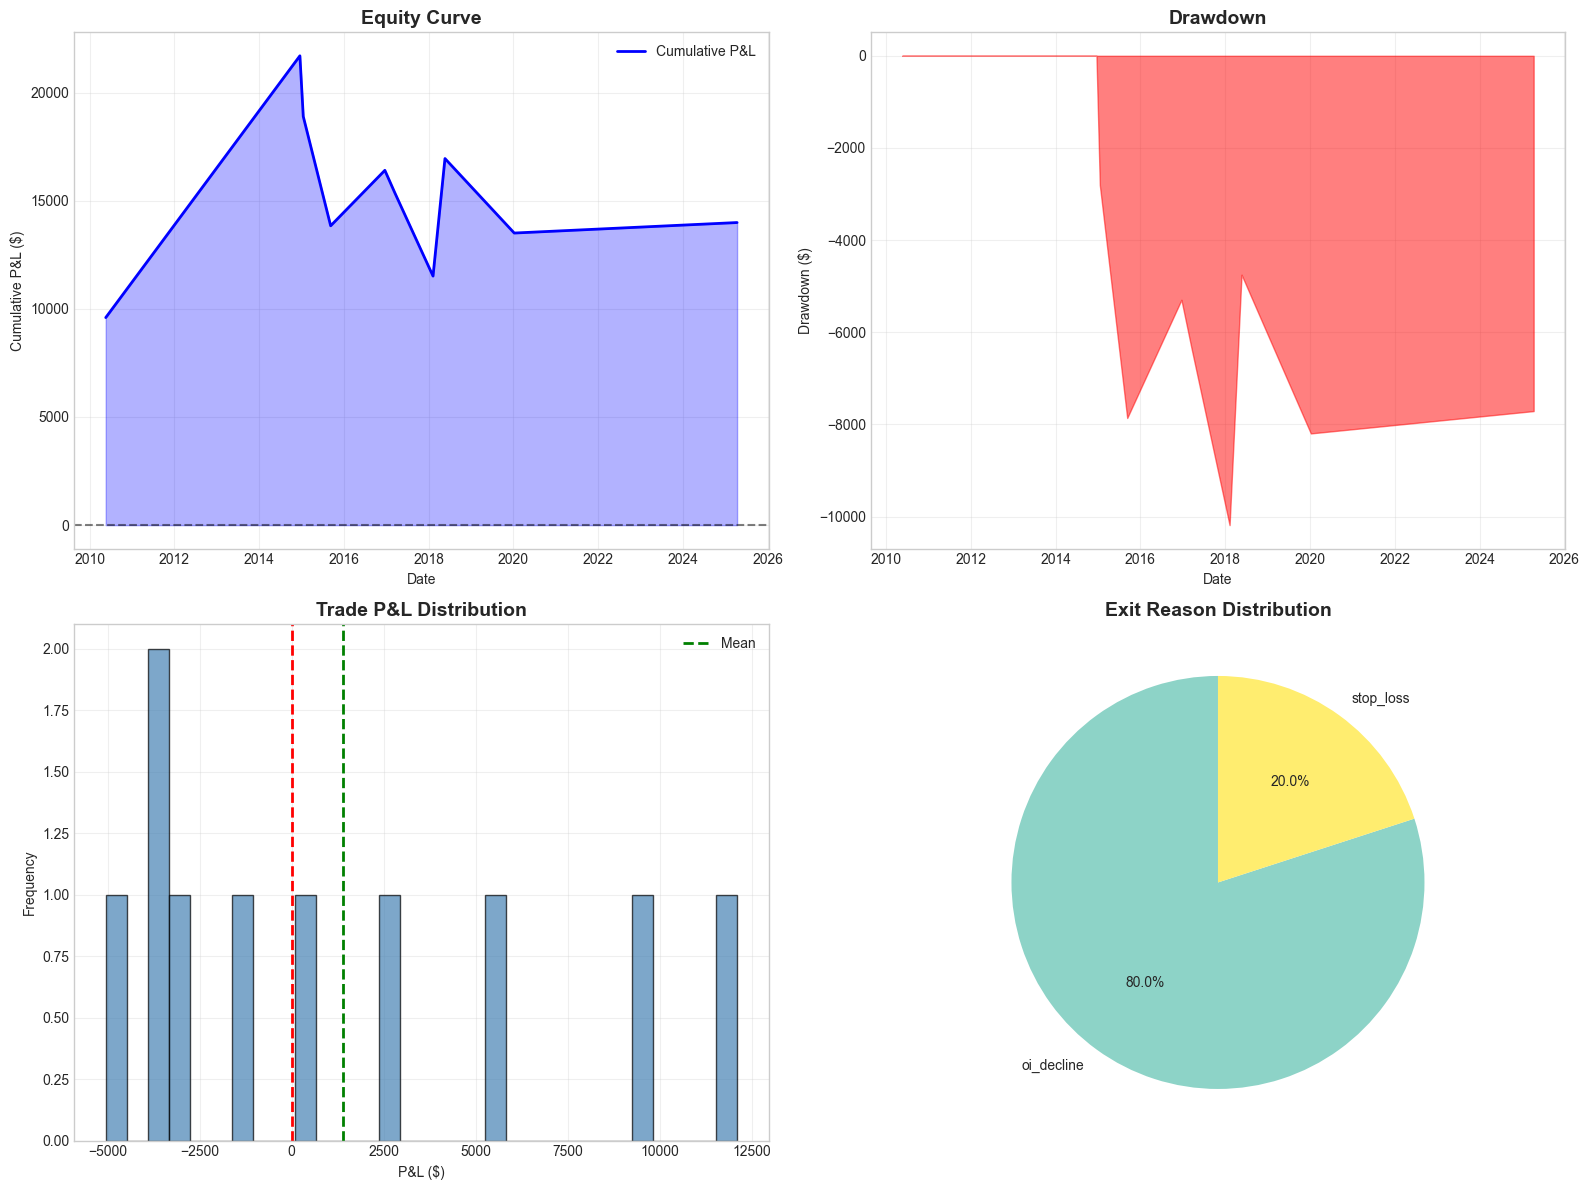

In [9]:
if len(trades_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Equity Curve
    ax1 = axes[0, 0]
    ax1.plot(trades_with_equity['exit_date'], trades_with_equity['cumulative_pnl'], 
             linewidth=2, color='blue', label='Cumulative P&L')
    ax1.fill_between(trades_with_equity['exit_date'], 0, trades_with_equity['cumulative_pnl'],
                     alpha=0.3, color='blue')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative P&L ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Drawdown
    ax2 = axes[0, 1]
    ax2.fill_between(trades_with_equity['exit_date'], 0, trades_with_equity['drawdown'],
                     color='red', alpha=0.5)
    ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown ($)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Trade P&L Distribution
    ax3 = axes[1, 0]
    colors = ['green' if x > 0 else 'red' for x in trades_df['pnl_dollars']]
    ax3.hist(trades_df['pnl_dollars'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.axvline(x=trades_df['pnl_dollars'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
    ax3.set_title('Trade P&L Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('P&L ($)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Exit Reason Pie Chart
    ax4 = axes[1, 1]
    exit_counts = trades_df['exit_reason'].value_counts()
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(exit_counts)))
    ax4.pie(exit_counts.values, labels=exit_counts.index, autopct='%1.1f%%', 
            colors=colors_pie, startangle=90)
    ax4.set_title('Exit Reason Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize.")

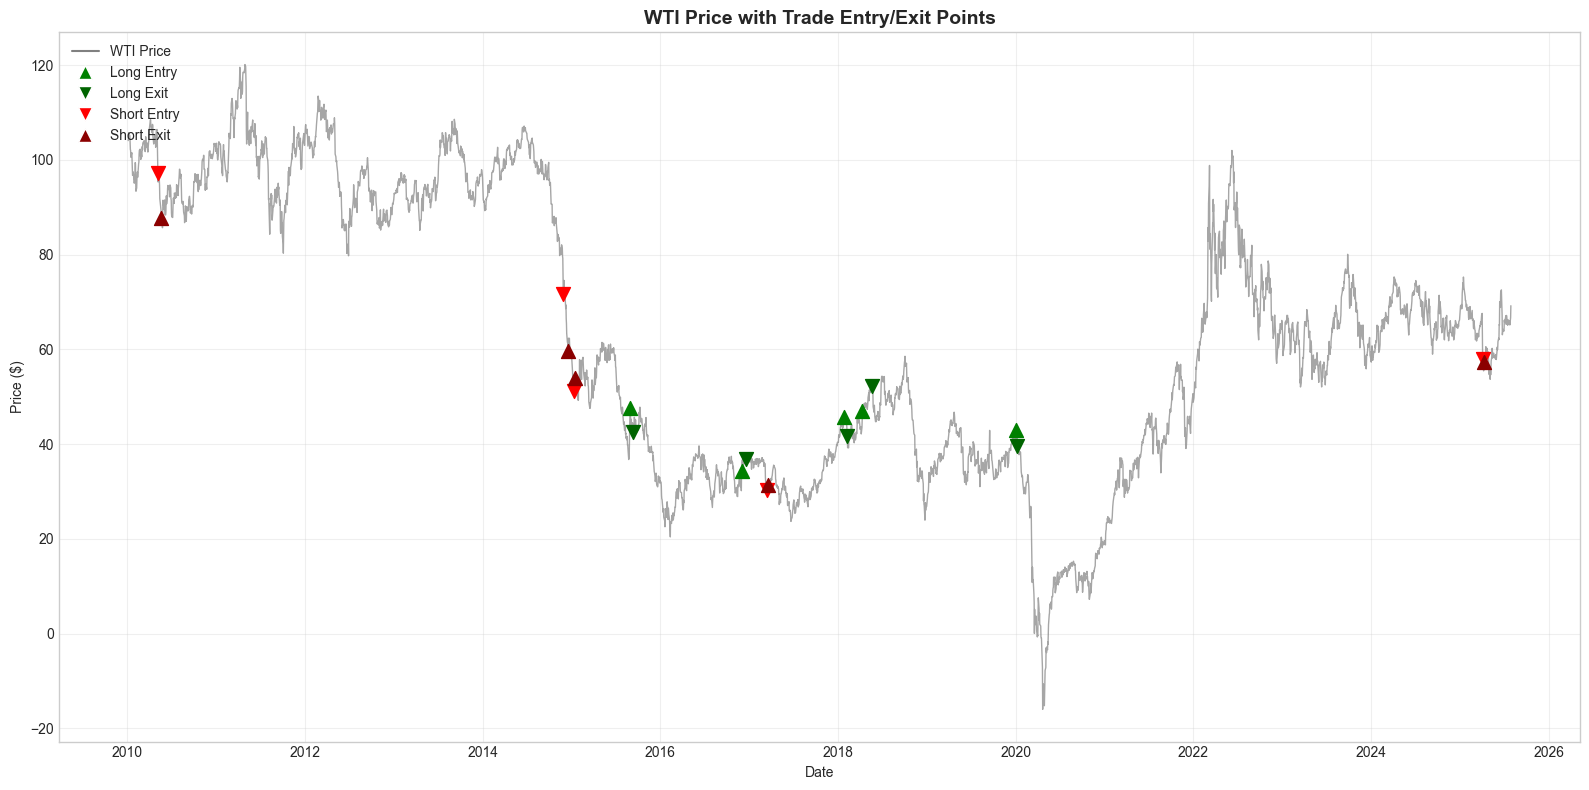

In [10]:
# Price chart with entry/exit points (sample period)
if len(trades_df) > 0:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot price
    ax.plot(df['date'], df['price'], linewidth=1, color='gray', alpha=0.7, label='WTI Price')
    
    # Plot long entries/exits
    long_trades = trades_df[trades_df['direction'] == 'long']
    for _, trade in long_trades.iterrows():
        ax.scatter(trade['entry_date'], trade['entry_price'], 
                   marker='^', color='green', s=100, zorder=5)
        ax.scatter(trade['exit_date'], trade['exit_price'], 
                   marker='v', color='darkgreen', s=100, zorder=5)
    
    # Plot short entries/exits
    short_trades = trades_df[trades_df['direction'] == 'short']
    for _, trade in short_trades.iterrows():
        ax.scatter(trade['entry_date'], trade['entry_price'], 
                   marker='v', color='red', s=100, zorder=5)
        ax.scatter(trade['exit_date'], trade['exit_price'], 
                   marker='^', color='darkred', s=100, zorder=5)
    
    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', label='WTI Price'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Long Entry'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='darkgreen', markersize=10, label='Long Exit'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Short Entry'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='darkred', markersize=10, label='Short Exit'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title('WTI Price with Trade Entry/Exit Points', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize.")

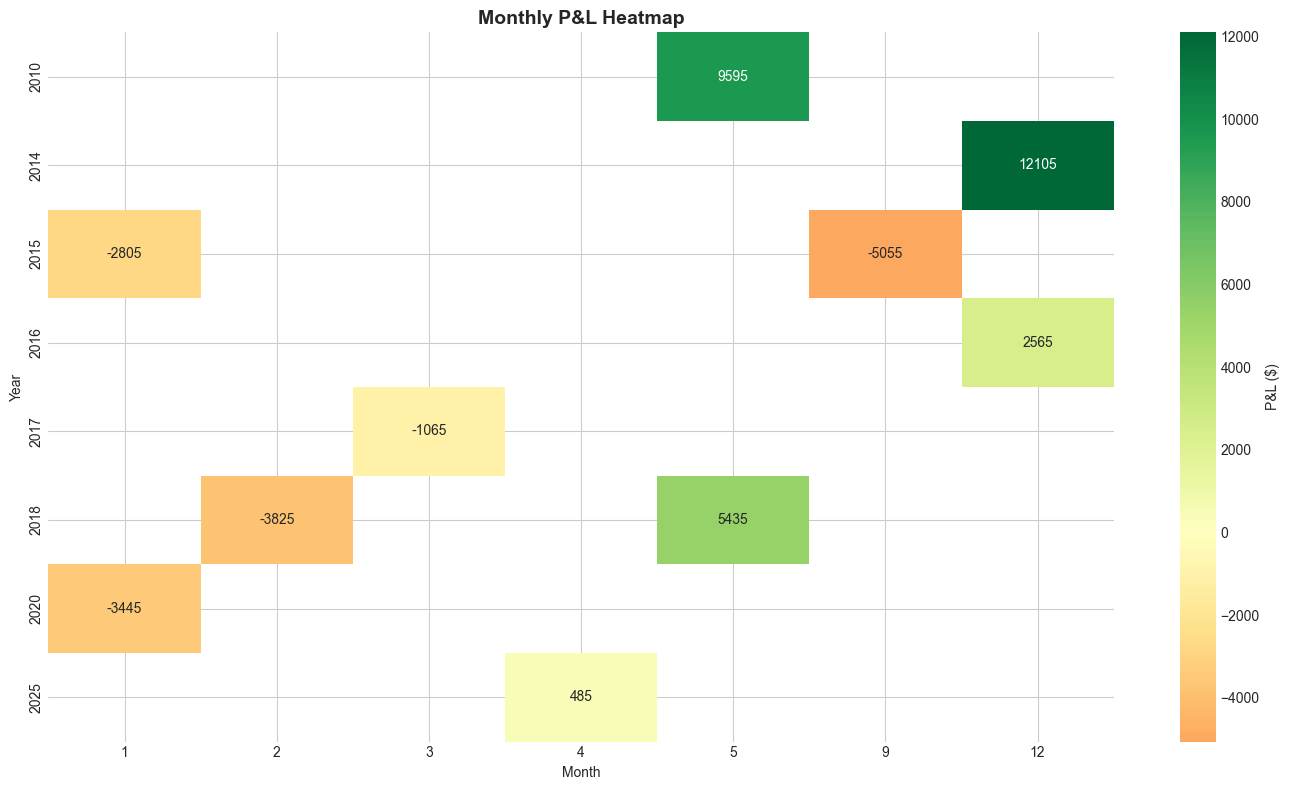

In [11]:
# Monthly P&L heatmap
if len(trades_df) > 0:
    trades_monthly = trades_df.copy()
    trades_monthly['year'] = trades_monthly['exit_date'].dt.year
    trades_monthly['month'] = trades_monthly['exit_date'].dt.month
    
    monthly_pnl = trades_monthly.groupby(['year', 'month'])['pnl_dollars'].sum().unstack()
    
    if not monthly_pnl.empty:
        fig, ax = plt.subplots(figsize=(14, 8))
        sns.heatmap(monthly_pnl, annot=True, fmt='.0f', cmap='RdYlGn', center=0,
                    ax=ax, cbar_kws={'label': 'P&L ($)'})
        ax.set_title('Monthly P&L Heatmap', fontsize=14, fontweight='bold')
        ax.set_xlabel('Month')
        ax.set_ylabel('Year')
        plt.tight_layout()
        plt.show()
else:
    print("No trades to visualize.")

## Cell 8: Summary & Observations

In [12]:
if len(trades_df) > 0:
    print("="*60)
    print("STRATEGY 1: TREND CONFIRMATION ENTRY - BACKTEST SUMMARY")
    print("="*60)
    print("\nStrategy Parameters:")
    print(f"  - Breakout period: {LOOKBACK_PERIOD} days")
    print(f"  - Volume threshold: {VOLUME_MULTIPLIER}x 20-day average")
    print(f"  - OI increase threshold: {OI_CHANGE_THRESHOLD*100}%")
    print(f"  - Stop loss: {STOP_LOSS_ATR_MULT}x ATR")
    print(f"  - Trailing stop: {TRAILING_STOP_ATR_MULT}x ATR")
    print(f"  - OI decline exit: {OI_DECLINE_EXIT_DAYS} consecutive days")
    
    print("\nKey Findings:")
    
    # Win rate analysis
    winners = len(trades_df[trades_df['pnl_dollars'] > 0])
    losers = len(trades_df[trades_df['pnl_dollars'] <= 0])
    win_rate = winners / len(trades_df)
    
    if win_rate > 0.5:
        print(f"  + Win rate of {win_rate:.1%} indicates positive edge")
    else:
        print(f"  - Win rate of {win_rate:.1%} below 50% - relies on large winners")
    
    # Profit factor analysis
    gross_profit = trades_df[trades_df['pnl_dollars'] > 0]['pnl_dollars'].sum()
    gross_loss = abs(trades_df[trades_df['pnl_dollars'] <= 0]['pnl_dollars'].sum())
    pf = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    if pf > 1.5:
        print(f"  + Profit factor of {pf:.2f} is attractive (>1.5)")
    elif pf > 1:
        print(f"  ~ Profit factor of {pf:.2f} is marginally profitable")
    else:
        print(f"  - Profit factor of {pf:.2f} indicates unprofitable strategy")
    
    # Trade frequency
    years = (df['date'].max() - df['date'].min()).days / 365.25
    trades_per_year = len(trades_df) / years
    print(f"  ~ Trade frequency: {trades_per_year:.1f} trades/year")
    
    # Direction bias
    long_pnl = trades_df[trades_df['direction'] == 'long']['pnl_dollars'].sum()
    short_pnl = trades_df[trades_df['direction'] == 'short']['pnl_dollars'].sum()
    print(f"  ~ Long P&L: ${long_pnl:,.0f} | Short P&L: ${short_pnl:,.0f}")
    
    print("\nPotential Improvements to Test:")
    print("  1. Adjust OI threshold (try 1%, 1.5%, 3%)")
    print("  2. Add trend filter (e.g., only trade in direction of 50-day SMA)")
    print("  3. Use ATR-based position sizing")
    print("  4. Add time-based exit (max holding period)")
    print("  5. Test on different periods (in-sample/out-of-sample split)")
else:
    print("No trades generated. Suggestions:")
    print("  1. Relax OI threshold (try 1% instead of 2%)")
    print("  2. Reduce volume multiplier (try 1.2x instead of 1.5x)")
    print("  3. Check data for missing values or issues")

STRATEGY 1: TREND CONFIRMATION ENTRY - BACKTEST SUMMARY

Strategy Parameters:
  - Breakout period: 20 days
  - Volume threshold: 1.5x 20-day average
  - OI increase threshold: 2.0%
  - Stop loss: 1.5x ATR
  - Trailing stop: 2.0x ATR
  - OI decline exit: 3 consecutive days

Key Findings:
  - Win rate of 50.0% below 50% - relies on large winners
  + Profit factor of 1.86 is attractive (>1.5)
  ~ Trade frequency: 0.6 trades/year
  ~ Long P&L: $-4,325 | Short P&L: $18,315

Potential Improvements to Test:
  1. Adjust OI threshold (try 1%, 1.5%, 3%)
  2. Add trend filter (e.g., only trade in direction of 50-day SMA)
  3. Use ATR-based position sizing
  4. Add time-based exit (max holding period)
  5. Test on different periods (in-sample/out-of-sample split)
